In [1]:
import sys
import localSettings as ls
print(ls.main_path)

/home/david/data/searchingfornues/v08_00_00_25/cc0pinp/1205/


In [2]:
import scipy.stats
import scipy.optimize

import numpy as np
import matplotlib.pyplot as plt
import uproot
import scipy.optimize
import matplotlib.gridspec as gridspec


import awkward

from matplotlib.colors import LogNorm

plt.rcParams.update({'font.size': 14})

import math

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

energy_range = (0.03,2.03)
energy_bins = 25

def gauss_exp(x, n, mu, sigma, k):
    sigma = abs(sigma)
    condition = (x - mu) / sigma >= -k    
    y = np.copy(x)
    y[condition] = n * np.exp(-0.5 * ((x[condition] - mu) / sigma)**2)
    y[~condition] = n * np.exp(k**2 / 2 + k * ((x[~condition] - mu) / sigma))
#     print(x)
    return y

def get_function_max(f, *args):
    def func(x, *arg):
        return -f(x, *arg)
    return f(scipy.optimize.fmin(func, 0, args=args, disp=False)[0], *args)

def find_nearest(array, value):
    array = np.asarray(array)
    #print (array)
    idx = (np.abs(array - value)).argmin()
    return idx

def mpv(array):
    if sum(array) < 5:
        return np.median(array)
    
    n_bins = energy_bins
    r = energy_range
    hist, bin_edges = np.histogram(array, bins=n_bins, range=r)
    
    bin_centers = [i*r[1]/n_bins-r[1]/(n_bins*2) for i in range(1,n_bins+1)]
    try:
        popt, pcov = scipy.optimize.curve_fit(gauss_exp, bin_centers, hist, maxfev=10000)
        return scipy.optimize.fmin(lambda x: -gauss_exp(x, *popt), 0)
    except RuntimeError:
        return np.median(array)
    
def fwhm(array):
    if sum(array) < 5:
        return np.std(array)

    n_bins = energy_bins
    r = energy_range
    hist, bin_edges = np.histogram(array, bins=n_bins, range=r)
    
    bin_centers = [i*r[1]/n_bins-r[1]/(n_bins*2) for i in range(1,n_bins+1)]

    try:
        popt, pcov = scipy.optimize.curve_fit(gauss_exp, bin_centers, hist, maxfev=10000)
        x_values = np.linspace(r[0], r[1], 1000)
        y_values = gauss_exp(np.linspace(r[0], r[1], 1000), *popt)
        try:
            x_max = scipy.optimize.fmin(lambda x: -gauss_exp(x, *popt), 0)
        except RuntimeError:
            x_max = np.median(array)
        y_max = find_nearest(y_values, gauss_exp(x_max, *popt))
        y_max_value = y_values[y_max]
        fwhm1 = find_nearest(y_values[:y_max], y_max_value/2)
        fwhm2 = find_nearest(y_values[y_max:], y_max_value/2)
        x_2 = x_values[y_max:][fwhm2]     
        x_1 = x_values[:y_max][fwhm1]
        return x_2-x_1
    except RuntimeError:
        return np.std(array)

In [3]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"
NUE = 'allnues'

UPROOTDF = uproot.open(ls.ntuple_path+NUE+".root")[fold][tree]

variables = ["elec_e", "shr_energy_tot_cali", "selected","nslice",\
             "trk_energy_tot","proton_e","n_tracks_contained",\
             "trk_llr_pid_score_v","trk_id",\
             "shr_energy_tot", "reco_nu_vtx_sce_x", "isVtxInFiducial"]

df = UPROOTDF.pandas.df(variables, flatten=False)

df['proton_ke'] = df['proton_e']-0.938

trk_llr_pid_v = UPROOTDF.array('trk_llr_pid_score_v')
trk_id = UPROOTDF.array('trk_id')-1 # I think we need this -1 to get the right result
trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
df['trkpid'] = trk_llr_pid_v_sel


QUERY = 'nslice == 1'
QUERY += ' and selected == 1'
QUERY += ' and n_tracks_contained > 0'
QUERY += ' and shr_energy_tot_cali > 0.07'
QUERY += ' and isVtxInFiducial == 1'
QUERY += ' and trkpid < -0.02'

df = df.query(QUERY)


In [4]:
# define resolution to be measured
RECOVAR = 'shr_energy_tot_cali'
TRUEVAR = 'elec_e'
EMIN = 0.03
EMAX = 2.03
NBINS = 20
EBINS = np.linspace(EMIN,EMAX,NBINS+1)
RESLOW = -1
RESHIGH = 1
VARIABLENAME = 'Electron Energy'

#RECOVAR = 'trk_energy_tot'
#TRUEVAR = 'proton_ke'
#EMIN = 0.05
#EMAX = 0.40
#NBINS = 20
#EBINS = np.linspace(EMIN,EMAX,NBINS+1)
#RESLOW = -0.4
#RESHIGH = 0.1
VARIABLENAME = 'Proton KE'

In [5]:
bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(
    df[TRUEVAR], df[RECOVAR], statistic=mpv, range=(EMIN,EMAX), bins=EBINS)

#bin_stdev, bin_edges, binnumber = scipy.stats.binned_statistic(
#    df[TRUEVAR], df[RECOVAR], statistic=fwhm, range=(EMIN,EMAX), bins=10)

/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimization terminated successfully.
         Current function value: -335.549631
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -2189.475391
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -2313.436189
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -1633.447591
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: -1229.457758
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: -832.655222
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: -596.187223
         Iterations: 23
         Function evaluations: 46
Optimizat

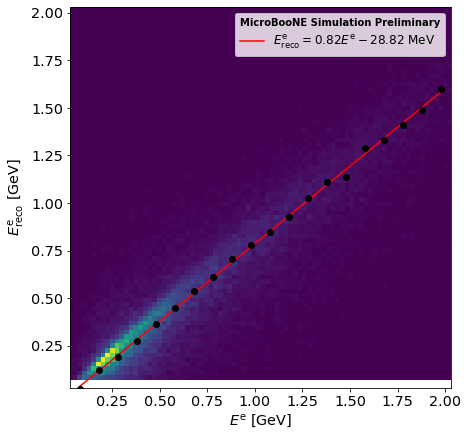

In [6]:
heatmap, xedges, yedges = np.histogram2d(df[TRUEVAR], df[RECOVAR], bins=200)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig, ax  = plt.subplots(figsize=(8,7))
ax.imshow(heatmap.T, extent=extent, origin='lower')#,norm=LogNorm())
bin_centers = (bin_edges + (bin_edges[1]-bin_edges[0])/2)[:-1]
ax.errorbar(
    bin_centers,
    bin_means,
    xerr=0.01,
    #yerr=bin_stdev/2,
    fmt='ko')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(bin_centers, bin_means)
ax.plot(bin_centers, intercept + slope*bin_centers, 'r', label=r'$E^{\mathrm{e}}_{\mathrm{reco}}=%.2f E^{\mathrm{e}} %.2f$ MeV' % (slope, intercept*1000))
leg = ax.legend(title=r'MicroBooNE Simulation Preliminary')
leg._legend_box.align = "left"
plt.setp(leg.get_title(), fontweight='bold')

ax.set_xlim(EMIN,EMAX)
ax.set_xlabel(r"$E^{\mathrm{e}}$ [GeV]")
ax.set_ylabel(r"$E^{\mathrm{e}}_{\mathrm{reco}}$ [GeV]")
ax.set_ylim(EMIN,EMAX)

fig.savefig(ls.plots_path+"e_calib.pdf")

/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a

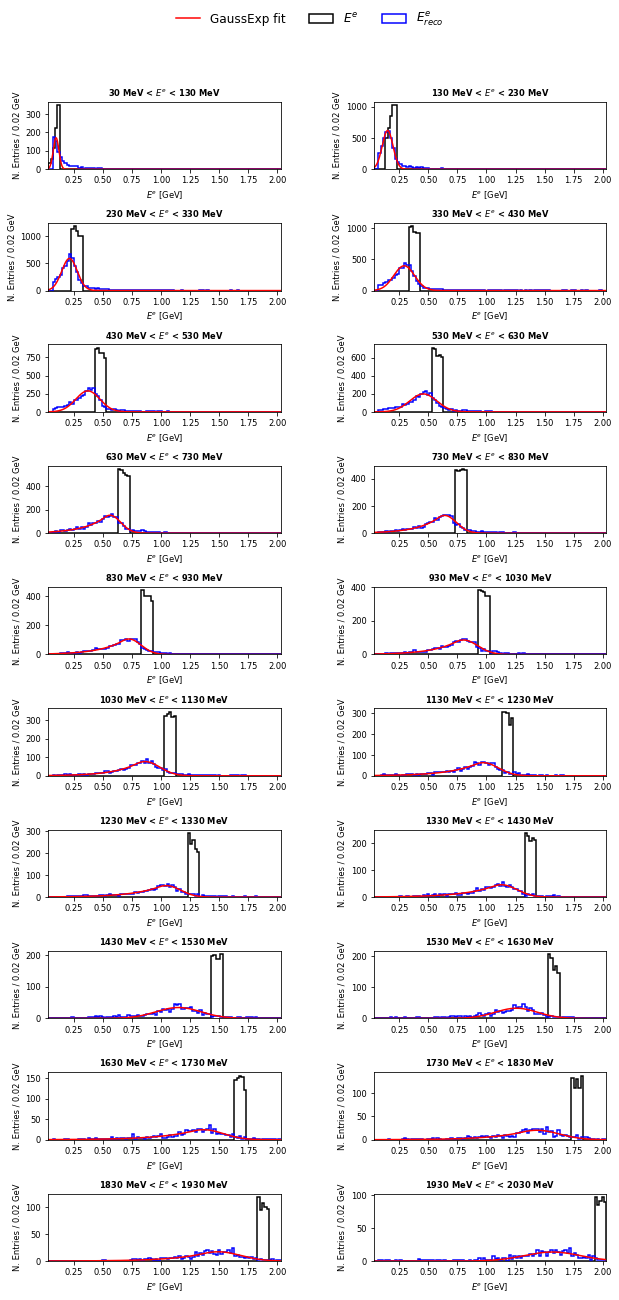

In [7]:
fig, ax = plt.subplots(figsize=(10, 20))
gs = gridspec.GridSpec(int(NBINS/2), 2, hspace=0.8, wspace=0.4)

params = {
    'legend.fontsize': 'large',
    'axes.labelsize': 'small',
    'axes.titlesize': 'small',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small'
}

pylab.rcParams.update(params)

for i in range(NBINS):
    df_bin = df.query("%f < %s < %f" % (EBINS[i],TRUEVAR,EBINS[i+1]))
    label_true = ""
    label_reco = ""
    label_fit = ""
    if i == 0:
        label_true = r"$E^e$"
        label_reco = r"$E^e_{reco}$"
        label_fit = r'GaussExp fit'

    plt.subplot(gs[i]).hist(
        df_bin[TRUEVAR],
        linewidth=1.5,
        bins=100,
        range=(EMIN,EMAX),
        histtype='step',
        color='k',
        label=label_true)

    hist, bin_edges, patches = plt.subplot(gs[i]).hist(
        df_bin[RECOVAR],
        linewidth=1.5,
        color='b',
        histtype='step',
        range=(EMIN,EMAX),
        bins=100,
        label=label_reco)

    r = (EMIN,EMAX)
    n_bins = 100

    bin_centers = [
        i * (r[1] - r[0]) / n_bins - (r[1] - r[0]) / (n_bins * 2) + r[0]
        for i in range(1, n_bins + 1)
    ]
    
    #print (bin_centers)
    
    popt, pcov = scipy.optimize.curve_fit(
        gauss_exp, bin_centers, hist, maxfev=10000)
    x_values = np.linspace(r[0], r[1], 1000)
    y_values = gauss_exp(np.linspace(r[0], r[1], 1000), *popt)
    plt.plot(x_values, y_values, color='r', label=label_fit)
    plt.subplot(gs[i]).set_xlim(EMIN,EMAX)
    plt.subplot(gs[i]).set_title(
        "%g MeV < $E^e$ < %g MeV" % (EBINS[i] * 1000,EBINS[i+1] * 1000),
        fontweight='bold')
    plt.subplot(gs[i]).set_xlabel(r"$E^e$ [GeV]")
    plt.subplot(gs[i]).set_ylabel(r"N. Entries / 0.02 GeV")

fig.legend(loc='upper center', ncol=3, frameon=False)
fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.savefig(ls.plots_path+"e_spectra.pdf")

fit-values are  [63.27171354  0.1         0.20779836  1.        ]
fit-values are  [5.12333003e+02 4.99992858e-02 1.55208540e-01 4.45020923e-01]
fit-values are  [6.58172346e+02 3.99636066e-02 1.58335830e-01 3.66880404e-01]
fit-values are  [6.02159071e+02 4.77179536e-02 1.49473677e-01 3.48751426e-01]
fit-values are  [5.51635142e+02 3.72760467e-02 1.41616980e-01 3.68095354e-01]
fit-values are  [4.28416066e+02 1.67525110e-02 1.70904820e-01 5.41446575e-01]
fit-values are  [3.52131610e+02 2.45514375e-02 1.48608672e-01 4.42513335e-01]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same argum

fit-values are  [3.32398255e+02 8.79916039e-03 1.57907594e-01 5.52513441e-01]
fit-values are  [3.02071940e+02 6.87240517e-03 1.52296942e-01 5.29587551e-01]
fit-values are  [2.75877211e+02 4.14871209e-03 1.56036150e-01 6.29281012e-01]
fit-values are  [ 2.70461764e+02 -1.77290123e-02  1.45609539e-01  6.42592780e-01]
fit-values are  [2.48073196e+02 1.58577366e-02 1.26034572e-01 5.04267683e-01]
fit-values are  [2.11084691e+02 4.25206315e-03 1.25177595e-01 5.36188639e-01]
fit-values are  [ 2.07835363e+02 -3.11441725e-03  1.24351282e-01  5.99360309e-01]
fit-values are  [ 1.68994012e+02 -3.93557946e-02  1.49870150e-01  8.39396353e-01]
fit-values are  [1.82257564e+02 4.25616982e-03 1.02598037e-01 4.97546679e-01]
fit-values are  [1.30730194e+02 1.58172235e-03 1.30613558e-01 6.01170333e-01]
fit-values are  [ 1.19509790e+02 -1.01553287e-02  1.30399377e-01  6.96237572e-01]
fit-values are  [ 1.03268718e+02 -2.85683751e-02  1.31940128e-01  7.34955856e-01]
fit-values are  [9.53563622e+01 9.89125161e-

/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


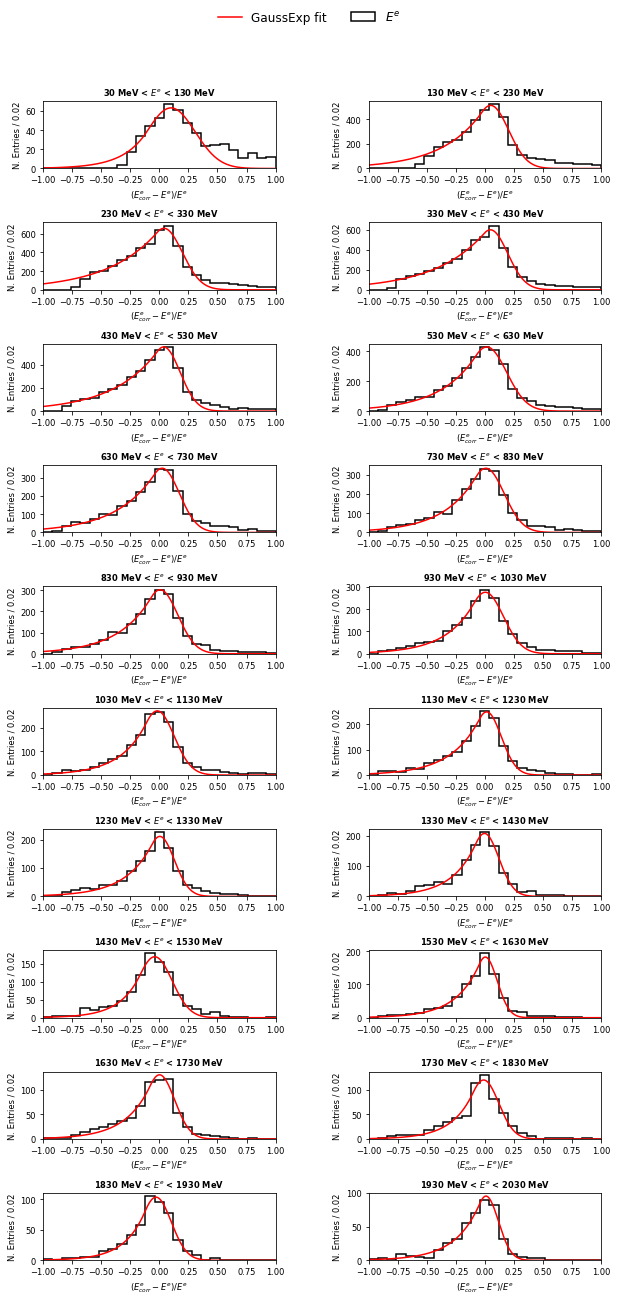

In [8]:
params = {
    'legend.fontsize': 'large',
    'axes.labelsize': 'small',
    'axes.titlesize': 'small',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small'
}

pylab.rcParams.update(params)

fig_res, ax_res = plt.subplots(figsize=(10, 20))
gs_res = gridspec.GridSpec(int(NBINS/2), 2, hspace=0.8, wspace=0.4)

sigma = np.array([])
sigma_err = np.array([])

for i in range(NBINS):
    df_bin = df.query("%f < %s < %f" %(EBINS[i],TRUEVAR,EBINS[i+1]))
    label_true = ""
    label_reco = ""
    label_fit = ""
    if i == 0:
        label_true = r"$E^e$"
        label_reco = r"$E^e_{reco}$"
        label_fit = r'GaussExp fit'

    #e_res = (df_bin[RECOVAR] - df_bin[TRUEVAR]) / df_bin[TRUEVAR]
    e_res = ( (df_bin[RECOVAR]/slope) - df_bin[TRUEVAR]) / df_bin[TRUEVAR]
    n_bins = 25

    hist, bin_edges, patches = plt.subplot(gs_res[i]).hist(
        e_res,
        linewidth=1.5,
        bins=n_bins,
        range=(RESLOW,RESHIGH),
        histtype='step',
        color='k',
        label=label_true)

    r = (RESLOW,RESHIGH)

    bin_centers = np.array([
        i * (r[1] - r[0]) / len(hist) - (r[1] - r[0]) / (len(hist) * 2) + r[0]
        for i in range(1, len(hist) + 1)
    ])

    #'''
    fit_range = np.logical_and(bin_centers < 0.5, bin_centers > -0.5)
    # n, mu, sigma, k
    popt, pcov = scipy.optimize.curve_fit(
        gauss_exp,
        bin_centers[fit_range],
        hist[fit_range],
        maxfev=10000,
        p0=(100,0.0,0.2,0.1),
        bounds=((0, -0.5, 0, 0), (1e4, 0.1, 1.0, 1)))
    
    print ('fit-values are ',popt)

    x_values = np.linspace(r[0], r[1], 1000)
    y_values = gauss_exp(np.linspace(r[0], r[1], 1000), *popt)
    sigma = np.append(sigma, popt[2])
    sigma_err = np.append(sigma_err, math.sqrt(np.diagonal(pcov)[2]))
    plt.plot(x_values, y_values, color='r', label=label_fit)
    plt.subplot(gs_res[i]).set_xlim(RESLOW,RESHIGH)
    plt.subplot(gs_res[i]).set_title(
        "%g MeV < $E^e$ < %g MeV" % (EBINS[i]*1000.,EBINS[i+1]*1000.),\
        fontweight="bold")
    plt.subplot(gs_res[i]).set_xlabel(r"$(E^e_{corr}-E^e)/E^e$")
    plt.subplot(gs_res[i]).set_ylabel(r"N. Entries / 0.02")
    #'''

fig_res.legend(loc='upper center', ncol=2, frameon=False)
fig_res.tight_layout()
fig_res.subplots_adjust(top=0.93)
fig_res.savefig(ls.plots_path+"res.pdf")

[0.20779835553839612, 0.1552085399535751, 0.15833582973134686, 0.14947367671519787, 0.14161698029261718, 0.17090482046132344, 0.14860867187223106, 0.15790759433108423, 0.15229694207009423, 0.15603615035632032, 0.14560953858908782, 0.12603457165042267, 0.12517759538624565, 0.12435128186010988, 0.14987015016338331, 0.10259803746217226, 0.13061355796862653, 0.13039937686075964, 0.1319401279755484, 0.10750797908003942]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


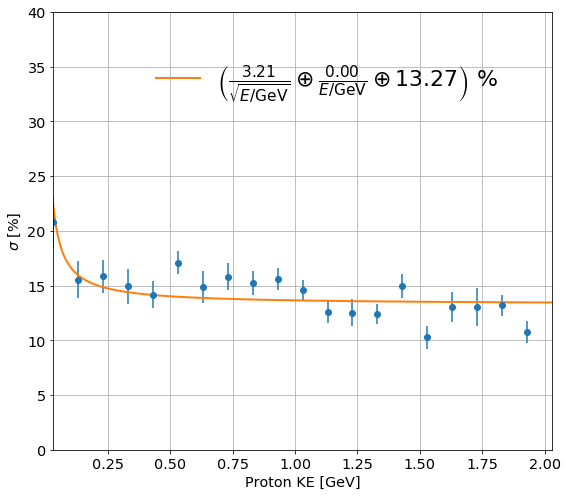

In [9]:
params = {
    'legend.fontsize': 'large',
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

fig, ax = plt.subplots(figsize=(8, 7))
x_centers = np.array([EBINS[i] * 1000 for i in range(NBINS)])


def res_fit(x, a, b, c):
    return np.sqrt((a / np.sqrt(x))**2 + (b / x)**2 + c**2)


print(list(sigma))

ax.errorbar(
    x_centers / 1000,
    sigma * 100,
    #xerr=0.1,
    yerr=sigma_err[0:] * 100,
    fmt='o',
    label=r"")

popt, pcov = scipy.optimize.curve_fit(
    res_fit,
    x_centers / 1000,
    sigma * 100,
    maxfev=10000,
    bounds=((0, 0, 0), (np.inf, np.inf, np.inf)),
    sigma=sigma_err * 100)


x_values = np.linspace(EMIN, EMAX, 1000)
y_values = res_fit(np.linspace(EMIN, EMAX, 1000), *popt)

plt.plot(
    x_values,
    y_values,
    linewidth=2,
    label=
    r'$\left(\frac{%.2f}{\sqrt{E / \mathrm{GeV}}}\oplus\frac{%.2f}{E / \mathrm{GeV}}\oplus %.2f\right)$ %%'
    % (popt[0], popt[1], popt[2]))

ax.set_ylim(0,40)
ax.set_xlim(EMIN, EMAX)
ax.set_xlabel(r"%s [GeV]"%VARIABLENAME)
ax.set_ylabel(r"$\sigma$ [%]")
plt.grid()

fig.legend(frameon=False, loc='best', bbox_to_anchor=(0.45, 0.45, 0.45, 0.45),fontsize=22)
fig.tight_layout()
fig.savefig(ls.plots_path+"sigma_res.pdf")